# Determine Data to Discard

In this notebook the full dataset (as stored in the pickle) is assessed and any data that is dropped from the analysis is documented. 

Note that the actual removal of the data is done in /src/loadPickle.py


*   Assume that inversions need to be removed from the Gazelle data (use of min/max thermometers), but *not* from the Valdivia or Planet. This is an assumption as both the Valdivia and Planet carried a variety of thermometer types (including reversing and electric thermometers), but it is not documented in the data tables which instrument was used for each observation. 
*   The Valdivia data is read from tables some of which have cryptic notations, and some of which combine data from several stations (although reported at a single lat/lon). Many of these are removed because of the uncertainty, as documented below.



In [ ]:
%%capture
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install geoplot
!pip install gsw
!pip install xarray
!pip install netcdf4
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!pip install regionmask

In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import pandas as pd
from scipy.optimize import lsq_linear
from typing import Iterable
from scipy import stats
import pyproj as proj
import scipy.interpolate as interpolate
import regionmask
import scipy.integrate as integrate

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import matplotlib.font_manager
#font = {'family': 'serif', 'serif': ['Palatino'], 'size': 14}
#plt.rc('font', **font)
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=False)
#plt.rc('text', usetex=False)

In [ ]:
# load the pickle to consider
cruise_df = pd.read_pickle('/content/drive/My Drive/WOD Historic Data/ALL_CRUISES_v0p8.pkl')
ac = cruise_df.to_xarray()
ac

<xarray.Dataset>
Dimensions:                    (index: 619)
Coordinates:
  * index                      (index) int64 0 1 2 3 4 5 ... 614 615 616 617 618
Data variables: (12/36)
    Station                    (index) object '38' '38' '38' ... '181' '181'
    Date                       (index) datetime64[ns] 1874-10-04 ... 1906-08-14
    Lat degrees                (index) float64 -34.0 -34.0 -34.0 ... -9.0 -9.0
    Lat minutes                (index) float64 -6.5 -6.5 -6.5 ... -18.0 -18.0
    Lon degrees                (index) float64 18.0 18.0 18.0 ... 112.0 112.0
    Lon minutes                (index) float64 6.5 6.5 6.5 6.5 ... 9.0 9.0 9.0
    ...                         ...
    temp_inversion_woa         (index) bool False False False ... True True True
    temp_inversion_hist        (index) bool False False False ... False False
    delta_T_monthly_5564       (index) float64 1.225 3.113 3.486 ... -0.8942 nan
    WOA_temp_monthly_5564      (index) float64 16.02 14.71 13.19 ... 8.706 nan
    delta_T_seasonal_5564      (index) float64 2.359 3.216 ... -0.7273 -0.2845
    WOA_temp_seasonal_5564     (index) float64 17.16 14.82 12.77 ... 8.873 1.416

## Inversions in WOA

First find Gazelle stations with a WOA inversion flag

Note that the interpolation function used to plot these is best seen in *CreatePickleAllCruises.ipynb*, with figure reproduced below.

12


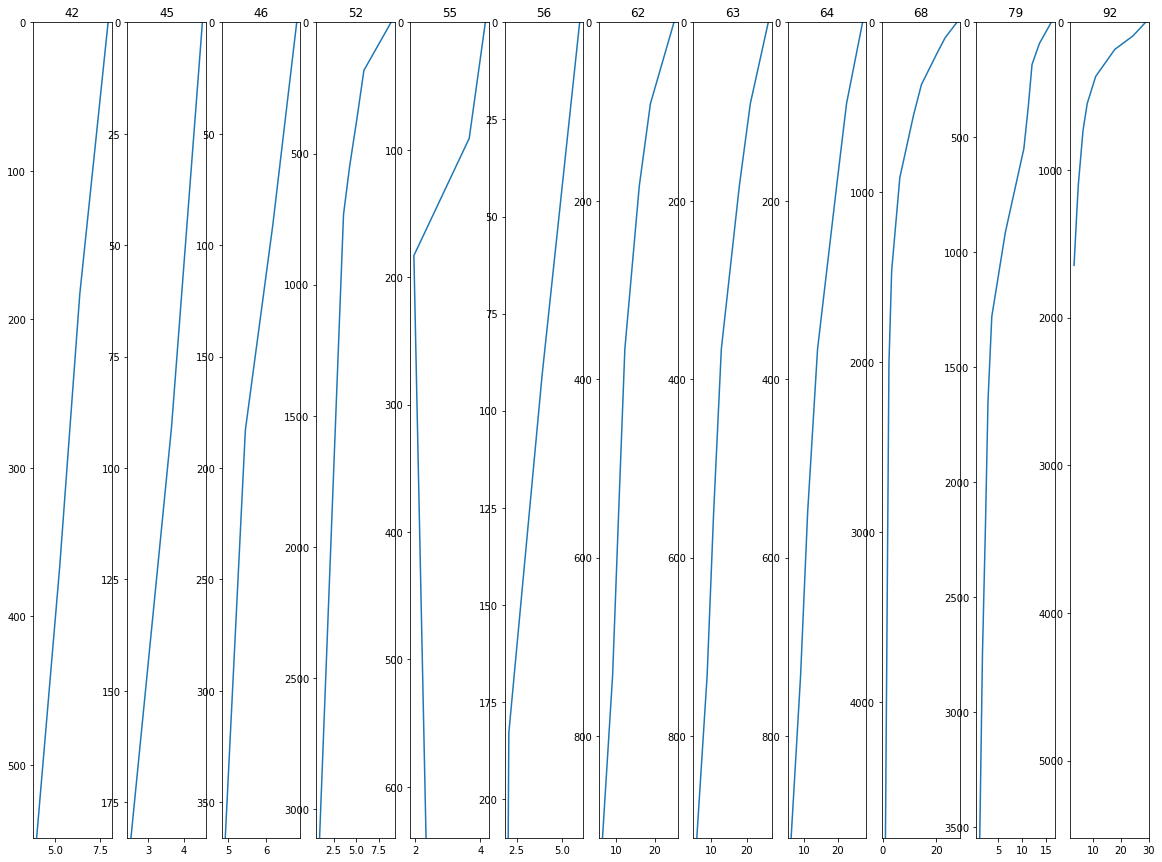

In [ ]:
# Here we can calculate and plot the 12 inversions in the Gazelle data, but the view is not clear
woa_inv = ac.where(ac.temp_inversion_woa, drop=True)
woa_inv = woa_inv.where(woa_inv.cruise == 'Gazelle', drop=True)
print(np.unique(woa_inv.Station.values).size)
fig, ax = plt.subplots(1,12, figsize=(20,15))
counter = 0
for s in np.unique(woa_inv.Station.values):
  #print(s)
  stat = woa_inv.where(woa_inv.Station==s, drop=True)
  ax.ravel()[counter].plot(stat.WOA_temp_seasonal_rgrd, stat.Depth)
  ax.ravel()[counter].set_title(f'{s}')
  ax.ravel()[counter].set_ylim(stat.Depth.max(), 0)
  counter += 1

Instead, see below (from CreatePickleAllCruises.ipynb) which shows every station with inversion in the WOA data. 

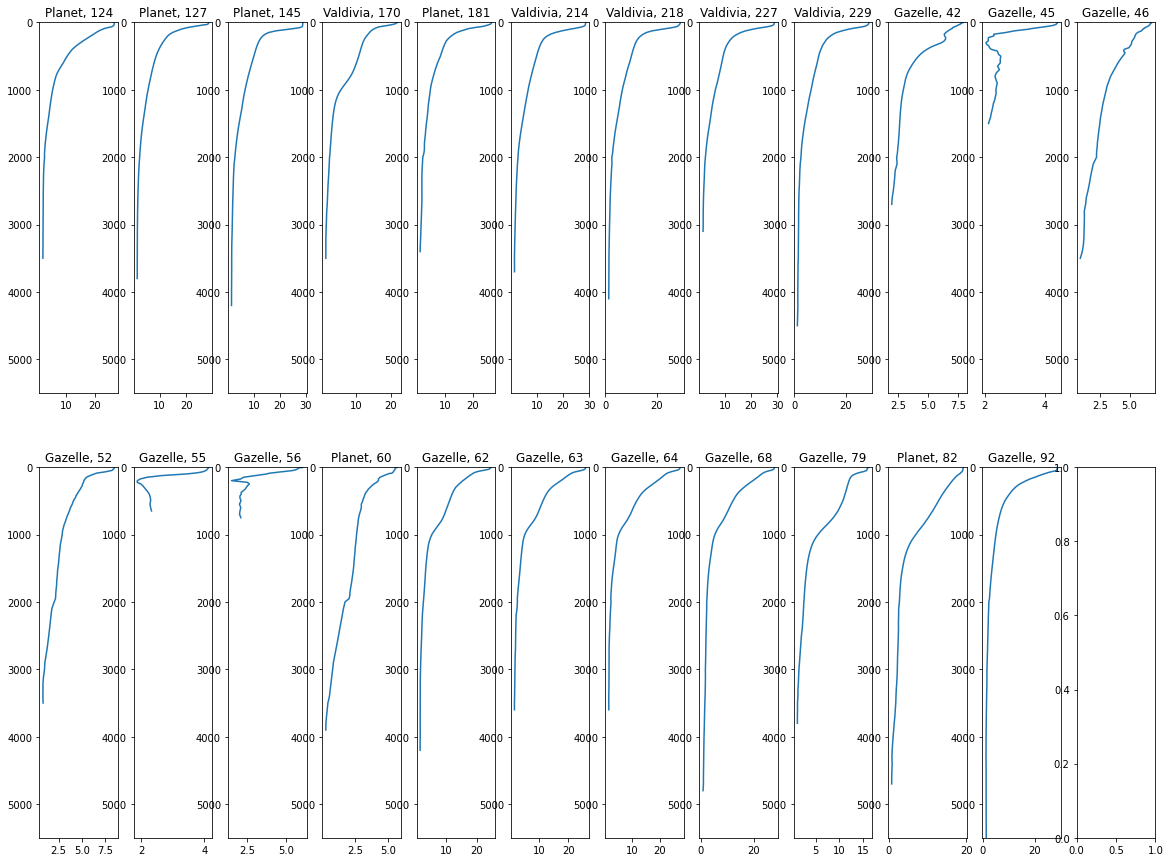

From this we determine to **remove Gazelle stations**:

`45, 55, 66`

Note that other ones could be removed (eg. 42, and 46) however these inversion are small relative to the depth variation, particularly considering the coarse vertical resolution of the Gazelle profiles, so we choose to retain them.

## Inversions in Gazelle

12


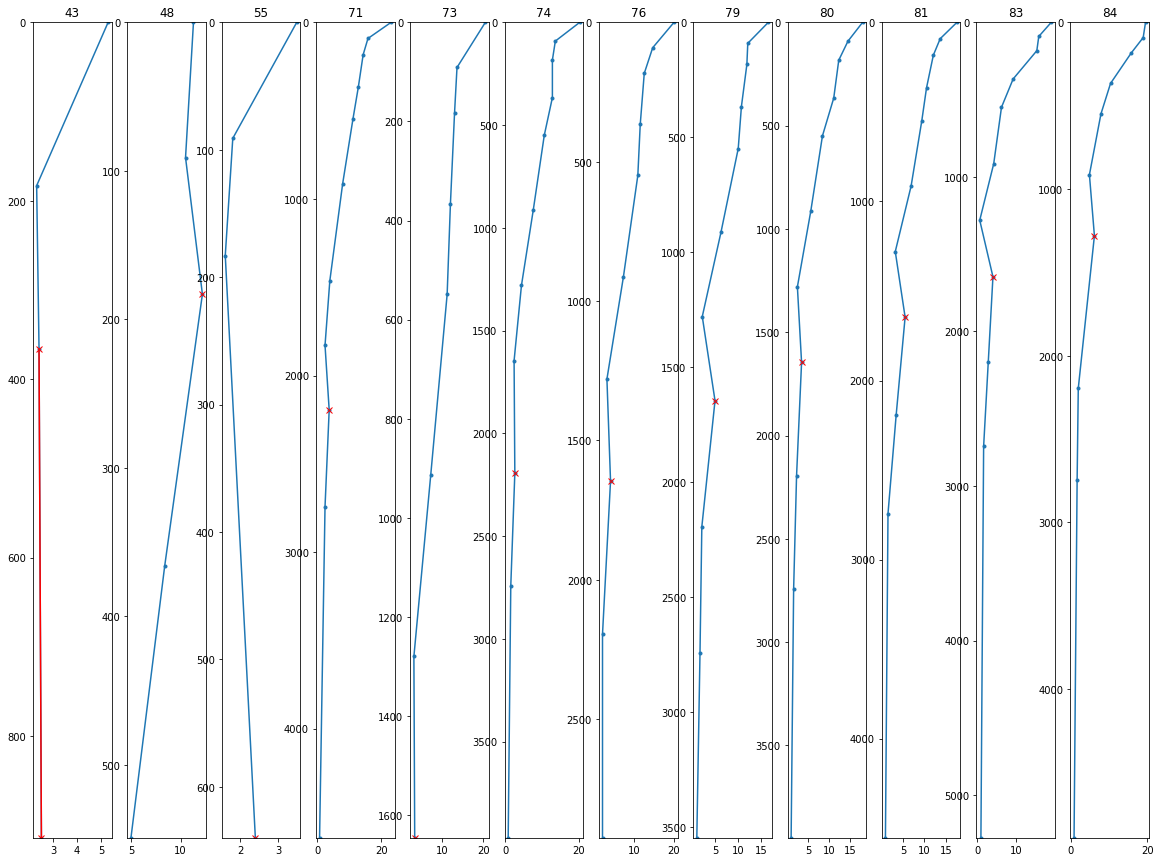

In [ ]:
# Here we can calculate and plot the 12 inversions in the Gazelle data, but the view is not clear
woa_inv = ac.where(ac.temp_inversion_hist, drop=True)
woa_inv = woa_inv.where(woa_inv.cruise == 'Gazelle', drop=True)
print(np.unique(woa_inv.Station.values).size)
fig, ax = plt.subplots(1,12, figsize=(20,15))
counter = 0
for s in np.unique(woa_inv.Station.values):
   #print(s)
   stat = woa_inv.where(woa_inv.Station==s, drop=True)
   ax.ravel()[counter].plot(stat.Temperature, stat.Depth, marker='.')
   posdz = np.insert(np.diff(stat.Temperature)>0, 0, False)
   ax.ravel()[counter].plot(stat.Temperature[posdz], stat.Depth[posdz], marker='x', color='r')
   ax.ravel()[counter].set_title(f'{s}')
   ax.ravel()[counter].set_ylim(stat.Depth.max(), 0)
   counter += 1

In [ ]:
station = '74'
woa_inv.where(woa_inv.Station==station, drop=True).Depth

<xarray.DataArray 'Depth' (index: 11)>
array([   0.,   91.,  183.,  366.,  549.,  914., 1280., 1646., 2195.,
       2743., 3968.])
Coordinates:
  * index    (index) int64 182 183 184 185 186 187 188 189 190 191 192

## Check Inversions in the other WOA data

10


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


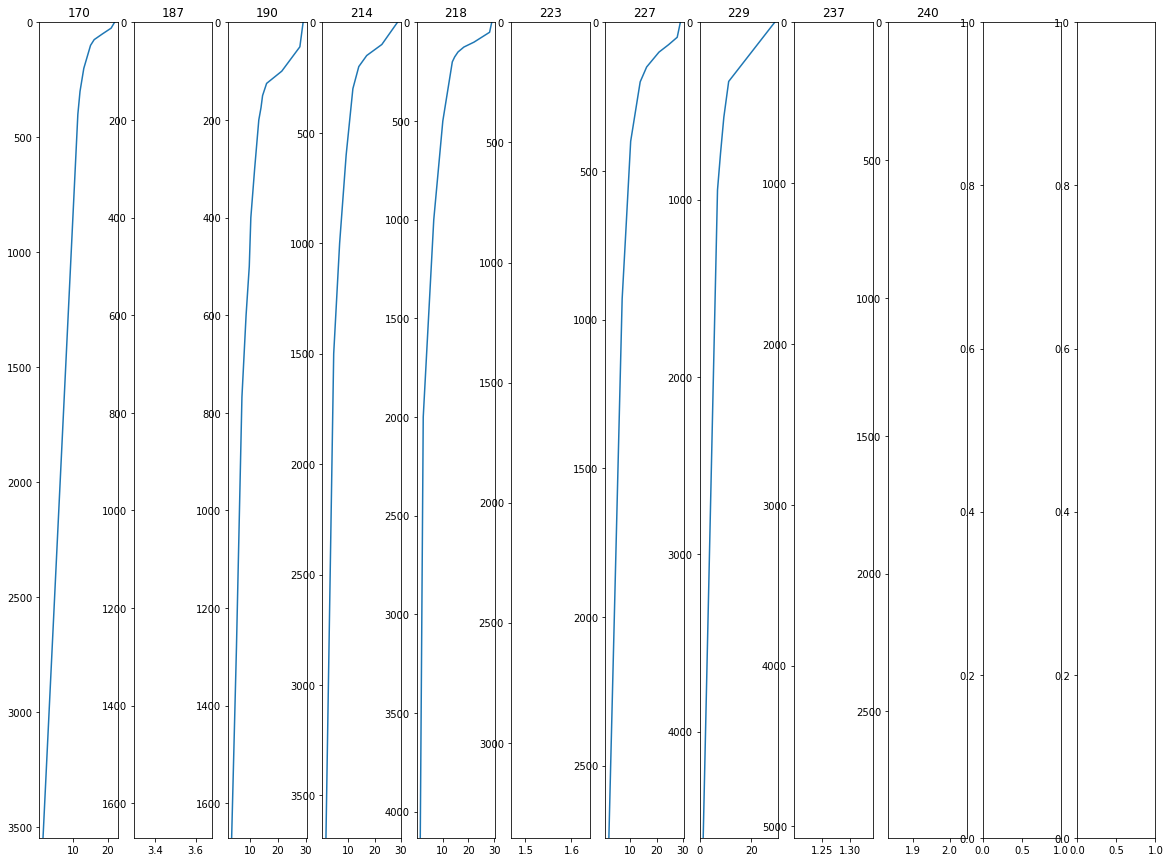

In [ ]:
# Check the inversions in the Valdivia data
woa_inv = ac.where(ac.temp_inversion_woa, drop=True)
woa_inv = woa_inv.where(woa_inv.cruise == 'Valdivia', drop=True)
print(np.unique(woa_inv.Station.values).size)
fig, ax = plt.subplots(1,12, figsize=(20,15))
counter = 0
for s in np.unique(woa_inv.Station.values):
  #print(s)
  stat = woa_inv.where(woa_inv.Station==s, drop=True)
  ax.ravel()[counter].plot(stat.WOA_temp_seasonal_rgrd, stat.Depth)
  ax.ravel()[counter].set_title(f'{s}')
  ax.ravel()[counter].set_ylim(stat.Depth.max(), 0)
  counter += 1

6


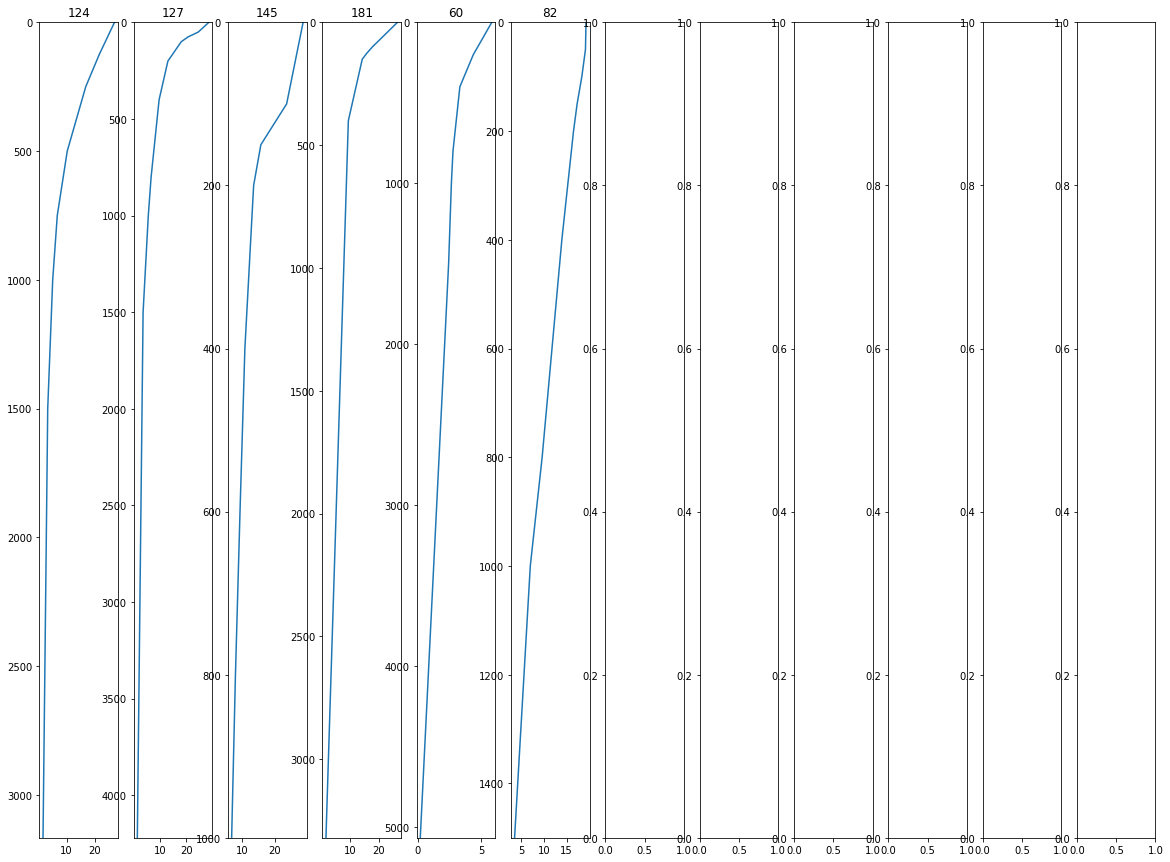

In [ ]:
# Check the inversions in the PLANET data
woa_inv = ac.where(ac.temp_inversion_woa, drop=True)
woa_inv = woa_inv.where(woa_inv.cruise == 'Planet', drop=True)
print(np.unique(woa_inv.Station.values).size)
fig, ax = plt.subplots(1,12, figsize=(20,15))
counter = 0
for s in np.unique(woa_inv.Station.values):
  #print(s)
  stat = woa_inv.where(woa_inv.Station==s, drop=True)
  ax.ravel()[counter].plot(stat.WOA_temp_seasonal_rgrd, stat.Depth)
  ax.ravel()[counter].set_title(f'{s}')
  ax.ravel()[counter].set_ylim(stat.Depth.max(), 0)
  counter += 1